# 概要
- 空室状況に応じた受注判断AIの構築
- 取り敢えず案件を受注するオペレーションで収益データを生成し、収益期待値を予測する機械学習モデル(y=f(X))を構築
- $f(X - a) + r_0 J > f(X)$の時、案件$r_0 J $を受注する

## parameter setting

In [7]:
!pip install -U pulp
!pip install japanize-matplotlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pulp
import copy
import seaborn as sns
import japanize_matplotlib

Requirement already up-to-date: pulp in /usr/local/lib/python3.7/dist-packages (2.4)
     |████████████████████████████████| 4.1MB 4.9MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp37-none-any.whl size=4120276 sha256=e5ebf3342024f8e7e1e66a38867b964568d60e65d6c0777a87823ad5bafce832
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


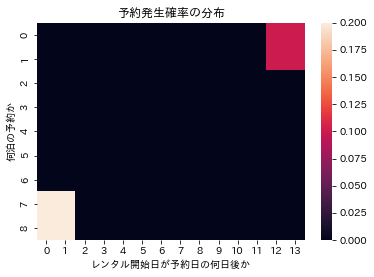

In [9]:
H=13 #予約日から予約開始日までの最大日数
T1=15 #何日先までの収益を予測するか
T2=60 #シミュレーションの日数
points=5 #1日の中で予約を受け付けるタイミング
C=2 #最大の在庫数
J=8 #最大の連泊数
lam=0.4 #時刻tにおける顧客の到着率
r0=100 #1泊のレンタル料金（ただし、料金=1泊あたりのレンタル料金×log(10*宿泊数+1)×宿泊数、と設定）
p=np.array( [[0.2 if (j>J-2)&(h<2) else 0.1 if (j<2)&(h>H-2) else 0. for h in range(H+1)] for j in range(J+1)] ) #顧客がh日後のj連泊を選択する確率

sns.heatmap(p)
plt.title('予約発生確率の分布')
plt.xlabel('レンタル開始日が予約日の何日後か')
plt.ylabel('何泊の予約か')
plt.show()

## 学習用データの作成

In [ ]:
#simulation
class Order:
  def __init__(self, x=[], T=T1, H=H, C=C, J=J, lam=lam, p=p):
    self.tp=0
    self.points=points
    self.H=H #予約までの最大日数
    self.T=T #シミュレーションの期間
    self.Tp=self.T*self.points
    self.C=C #最大の在庫数
    self.J=J #最大の連泊数
    if len(x)>0:
      self.x1= copy.copy(x) #X[i]はレンタル時刻iにおける在庫の予約数
      self.x3= copy.copy(x) #X[i]はレンタル時刻iにおける在庫の予約数
      self.sim_mode = 1 #この場合、x1についてのみシミュレーション実行
    else:
      self.x1= np.zeros(self.T, dtype=int) + C #X[i]はレンタル時刻iにおける在庫の予約数
      self.x2= np.zeros(self.T, dtype=int) + C #X[i]はレンタル時刻iにおける在庫の予約数
      self.x3= np.zeros(self.T, dtype=int) + C #X[i]はレンタル時刻iにおける在庫の予約数
      self.sim_mode = 2 #この場合、x1, x2についてシミュレーション実行
    self.revenue1=[]
    self.revenue2=[]
    self.revenue3=[]
    self.lam=lam #時刻tにおける顧客の到着率
    self.r0=r0 #1泊のレンタル料金
    self.p=p #顧客がh日後のj連泊を選択する確率
    self.ph=self.p[1][1:]/self.p[1][1:].sum()

  def receive_oder(self):
    #self.num_customers = np.random.binomial(1, self.lam)
    self.num_customers = np.random.binomial(1, self.lam * p.sum())
    hj=np.random.choice(
        a=np.array([[10000*j+h for h in range(H+1)] for j in range(J+1)]).flatten(), 
        p=p.flatten()/p.sum())
    self.term_resavation = hj % 10000
    self.after = hj // 10000
    #self.term_resavation = 1 if np.random.binomial(1, 0.5) else J
    #self.after = np.random.choice([h for h in range(1, self.H+1)], p=self.ph)

  def reserve_room(self):
    self.t=int(self.tp/self.points)
    #print(self.t)
    start = min(self.t+self.after, self.T-1)
    end = min(start+self.term_resavation, self.T-1)
    term = end - start
    if self.num_customers*(end>start) == 0: return
    if (self.x1[start:end] < 1).sum() == 0:
      #とりあえず予約を受け付ける場合（短期オペ）
      self.x1[start:end] = self.x1[start:end] - 1
      self.revenue1.append(self.r0 * term * np.log(term*10+1))

    # 期待収益計算に基づき予約を受け付ける場合（機械学習アプローチ）
    if self.sim_mode==2:
      if (self.x2[start:end] < 1).sum() == 0:
        jd = judge(self.x2, self.after, start, term, self.t, self.tp)
        if jd >= 0:
          self.x2[start:end] = self.x2[start:end] -1
          self.revenue2.append(self.r0 * term * np.log(term*10+1))

    #2日以上の予約のみ受け付ける場合（長期オペ）
    if ((self.x3[start:end] < 1).sum() == 0) & (term>1):
      self.x3[start:end] = self.x3[start:end] - 1
      self.revenue3.append(self.r0 * term * np.log(term*10+1))

  def pass_one_day(self):
    self.receive_oder()
    self.reserve_room()
    self.tp += 1
  
  def simulate(self):
    for i in range(self.Tp):
      self.pass_one_day()

In [ ]:
%%time
revenue = []
X = []

for i in range(1000):
  x = np.random.choice([i for i in range(C+1)], size=T1)
  rev = []
  for j in range(500):
    order = Order(x)
    order.simulate()
    rev.append(sum(order.revenue1))
  revenue.append(np.mean(rev))
  X.append(x)

X2 = pd.DataFrame(
    data = X,
    columns = ['X_'+ str(i) for i in range(T1)]
).assign(
    revenue = revenue
)

CPU times: user 59min 36s, sys: 6.69 s, total: 59min 43s
Wall time: 59min 51s


In [ ]:
files_path = './drive/My Drive/Analytics/Dynamic Pricing/受注判定AI開発/'
X2.to_csv(files_path + 'X2.csv')

In [ ]:
files_path = './drive/My Drive/Analytics/Dynamic Pricing/受注判定AI開発/'
X2  = pd.read_csv(files_path + 'X2.csv')
X2 = X2.iloc[:,1:]

## XからRevenueを予測するアルゴリズム

In [ ]:
# 比較対象のモデル
import pandas as pd
from pandas import DataFrame
import warnings

from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble

ridge = linear_model.Ridge()
lasso = linear_model.Lasso()
lsvr = svm.LinearSVR()
csvr = svm.SVR()
kmeans = neighbors.KNeighborsRegressor()
dtree = tree.DecisionTreeRegressor()
rf = ensemble.RandomForestRegressor(random_state=0)

# パラメータの定義
param_ridge={'alpha':[0.1,1.0,100.0,1000.0]}
param_lasso={'alpha':[0.1,1.0,100.0,1000.0]}
param_ls={'C':[0.1,1.0,100.0,1000.0]}
param_cs={'C':[0.1,1.0,100.0,1000.0]}
param_km={'n_neighbors':[1,3,5,7,9]}
param_dt={'max_depth':[1,3,5,7,9]}
param_rf={'max_depth':[1, 5]}

In [ ]:
# 1つのモデルに対して精度検証を行うモジュール
def Test(model, param_grid, X, y):  
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV
    
    # 学習データの設定
    ## 学習データ検証データの分離
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=66)
    ## データ標準化
    sc = StandardScaler()
    sc.fit(X_train)
    X_train, X_test = sc.transform(X_train), sc.transform(X_test)

    # 交差検証によるグリッドサーチ
    #grid_search = GridSearchCV(model,param_grid,cv=5,scoring='neg_mean_squared_error') 
    grid_search = GridSearchCV(model,param_grid,cv=5,scoring='neg_mean_absolute_error') 
    grid_search.fit(X_train, y_train)
    return {
        'train':grid_search.score(X_train,y_train), 
        'test':grid_search.score(X_test,y_test),
        'model':grid_search,
        'y_obs':y_test,
        'y_pred':grid_search.predict(X_test)
    }

In [ ]:
# 予測結果の可視化ルーチン
def VisualizationResults(results, bestmodel):
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    ## Methods比較
    results.loc[['train', 'test'], :].applymap(lambda x: -x).T.plot(
        ax=axes[0], kind='bar',title='Comp Methods')

    ## 予実比較
    axes[1].set_title('%s: Pred vs Obs' %(bestmodel))
    y_obs = results.loc['y_obs',bestmodel]
    y_pred = results.loc['y_pred',bestmodel]
    x_min, x_max = y_obs.min(),  y_obs.max()
    x=np.linspace(x_min, x_max, 100)
    y=x*1
    axes[1].plot(x, y, c='Blue')
    axes[1].scatter( x=y_obs, y=y_pred, c='Blue', s=10, alpha=0.5)
    axes[1].set_xlabel('Obs')
    axes[1].set_ylabel('Pred')

    plt.show()

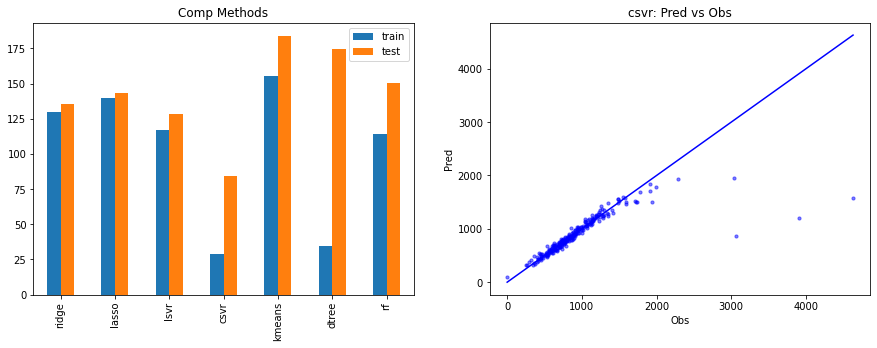

In [ ]:
# 予測実行
## 比較対象のモデル
ridge = linear_model.Ridge()
lasso = linear_model.Lasso()
lsvr = svm.LinearSVR()
csvr = svm.SVR()
kmeans = neighbors.KNeighborsRegressor()
dtree = tree.DecisionTreeRegressor()
rf = ensemble.RandomForestRegressor(random_state=0)

## パラメータの定義
param_ridge={'alpha':[0.1,1.0,100.0,1000.0]}
param_lasso={'alpha':[0.1,1.0,100.0,1000.0]}
param_ls={'C':[0.1,1.0,100.0,1000.0]}
param_cs={'C':[0.1,1.0,100.0,1000.0]}
param_km={'n_neighbors':[1,3,5,7,9]}
param_dt={'max_depth':[1,3,5,7,9]}
param_rf={'max_depth':[1, 5]}

## 予測の実行
warnings.simplefilter('ignore')

X = X2.drop(columns='revenue')
y = X2.revenue

results = DataFrame({
    'ridge':Test(model=ridge, param_grid=param_ridge, X=X, y=y),
    'lasso':Test(model=lasso, param_grid=param_ridge, X=X, y=y),
    'lsvr':Test(model=lsvr, param_grid=param_ls, X=X, y=y),
    'csvr':Test(model=csvr, param_grid=param_cs, X=X, y=y),
    'kmeans':Test(model=kmeans, param_grid=param_km,X=X, y=y),
    'dtree':Test(model=dtree, param_grid=param_dt, X=X, y=y),
    'rf':Test(model=rf, param_grid=param_rf, X=X, y=y)
})

VisualizationResults(results, bestmodel='csvr')

In [ ]:
X2

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,revenue
0,1,2,0,0,2,1,0,2,0,1,1,2,2,1,0,1173.862350
1,0,0,0,0,1,1,1,1,1,2,2,0,2,1,2,1063.927404
2,0,0,1,1,2,1,1,1,0,2,0,1,1,2,1,1025.771326
3,1,1,1,2,1,0,1,1,2,2,1,1,2,0,2,875.231775
4,2,0,2,2,0,2,2,2,0,2,0,2,2,2,2,1377.910145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,2,2,2,0,2,1,1,1,0,1,1,1,2,2,1102.584910
996,0,0,2,1,1,1,1,2,1,0,2,1,1,2,2,1186.040386
997,0,1,0,1,0,1,2,2,1,2,0,2,2,2,1,1486.323091
998,1,0,0,1,2,1,2,1,0,0,0,2,1,2,1,875.408666


# 機械学習アプローチに基づく受注判断シミュレーション

In [ ]:
# 機械学習アプローチに基づく判断基準の定義
import copy
best_model = results['csvr'].model.best_estimator_
#best_model = estimator

def judge(xx, after, start, term, t, tp):
  if (T2-t)<T1:
    res = 1.
  else:
    XX = copy.copy(xx[t:t+T1])
    XX2 = copy.copy(xx[t:t+T1])
    XX2[after:min(T1, after+term)] = XX2[after:min(T1, after+term)] - 1
    r1 = best_model.predict([XX])[0]
    #r1 = best_model.predict(np.array([XX]))
    r2 = r0 * term *  np.log(term*10.+1.) + best_model.predict([XX2])[0]
    #r2 = r0 * term *  np.log(term*10.+1.) + best_model.predict(np.array([XX2]))
    res = r2 - r1
  return res

In [ ]:
# モンテカルロシミュレーションの実行
rate1 = [] # 機械学習アプローチ vs 短期オペ
rate2 = [] # 長期オペ vs 短期オペ
rate3 = [] # 機械学習アプローチ vs 長期オペ
for i in range(1000):
  order = Order(x=[], T=T2)
  order.simulate()
  rate1.append(sum(order.revenue2)/(sum(order.revenue1)))
  rate2.append(sum(order.revenue3)/(sum(order.revenue1)))
  rate3.append(sum(order.revenue2)/(sum(order.revenue3)))

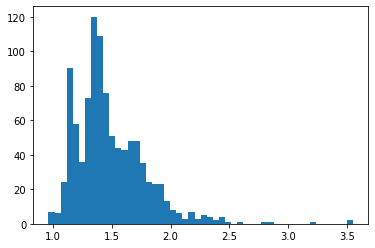

1.4853583828620136

In [ ]:
# 機械学習アプローチ vs 短期オペ
plt.hist(rate1, bins=50)
plt.show()
np.mean(rate1)

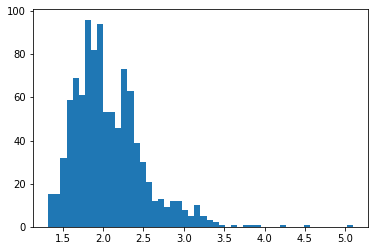

2.0720116149807817

In [ ]:
# 長期オペ vs 短期オペ
plt.hist(rate2, bins=50)
plt.show()
np.mean(rate2)

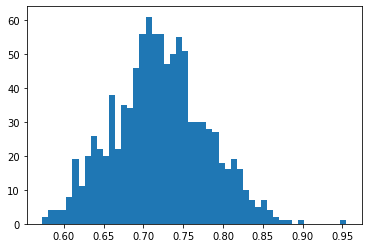

0.7209056102603504

In [ ]:
# 機械学習アプローチ vs 長期オペ
plt.hist(rate3, bins=50)
plt.show()
np.mean(rate3)